In [4]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
import survivors.datasets as ds

import warnings
warnings.filterwarnings("ignore")

In [6]:
X1, y1, features1, categ1, _ = ds.load_backblaze_2016_2018()
X2, y2, features2, categ2, _ = ds.load_backblaze_2018_2021()
X3, y3, features3, categ3, _ = ds.load_backblaze_2021_2023()

<Axes: xlabel='time', ylabel='Density'>

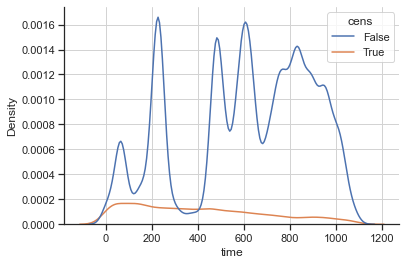

In [29]:
sns.kdeplot(pd.DataFrame(y1), x="time", hue="cens", bw_adjust=0.7)

<Axes: xlabel='time', ylabel='Density'>

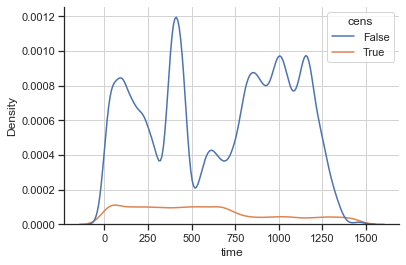

In [30]:
sns.kdeplot(pd.DataFrame(y2), x="time", hue="cens", bw_adjust=0.7)

<Axes: xlabel='time', ylabel='Density'>

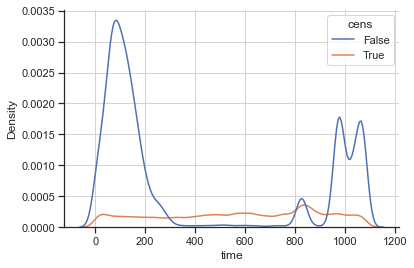

In [33]:
sns.kdeplot(pd.DataFrame(y3), x="time", hue="cens", bw_adjust=0.4)

In [23]:
# from datetime import datetime
# datetime.strptime("2021-12-31", "%Y-%m-%d") - datetime.strptime("2018-01-01", "%Y-%m-%d")

In [47]:
df = X.fillna(0).copy()
df["time"] = y["time"]
df["event"] = y["cens"]

In [ ]:
import lifelines

#Fitting the model
model = lifelines.CoxPHFitter(penalizer=0.01).fit(df, duration_col='time', event_col='event')
#Assumption check
model.check_assumptions(df, p_value_threshold=0.05, show_plots=True)

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines.datasets import load_gbsg2
from lifelines import CoxPHFitter, WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter
from lifelines.statistics import proportional_hazard_test, logrank_test

In [123]:
from lifelines import KaplanMeierFitter

def check_assumption(df):
    kmf = KaplanMeierFitter()
    kmf.fit(df['time'], event_observed=df['event'])

    typical_case = df.drop(columns=['time', 'event']).median().to_frame().T
    timeline = np.linspace(1, df['time'].max(), 500)

    # plt.figure(figsize=(7, 5))
    # kmf.plot_survival_function(label='Kaplan-Meier (эмпирическая)', ci_show=True)
    # for M in [WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter]:
    #     model = M(penalizer=0.001)
    #     model.fit(df, duration_col='time', event_col='event')
    #     surv = model.predict_survival_function(typical_case, times=timeline)
    #     plt.plot(timeline, surv.T.values[0], label=f'{model.__class__.__name__}', linestyle='--')

    # plt.title("Сравнение функций выживания")
    # plt.xlabel("Время")
    # plt.ylabel("S(t)")
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()
    
    quantiles = np.linspace(0.3, 0.99, 100)
    kmf_qs = [kmf.percentile(q) for q in quantiles]
    
    fig = plt.figure(figsize=(6, 4))
    for M in [WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter]:
        model = M(penalizer=0.01)
        model.fit(df, duration_col='time', event_col='event')
        models_qs = [model.predict_percentile(typical_case, p=q).iloc[0] for q in quantiles]
        plt.plot(kmf_qs, models_qs, label=f'{model.__class__.__name__[:-6]}', linestyle='--', linewidth=3)

    plt.plot(kmf_qs, kmf_qs, color="red", label="Best similarity", linewidth=3)
    fig.set_dpi(300)
    plt.ylim(0, 3000)
    plt.xlabel("Quantiles of the theoretical time distribution")
    plt.ylabel("Quantiles of the empirical time distribution")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

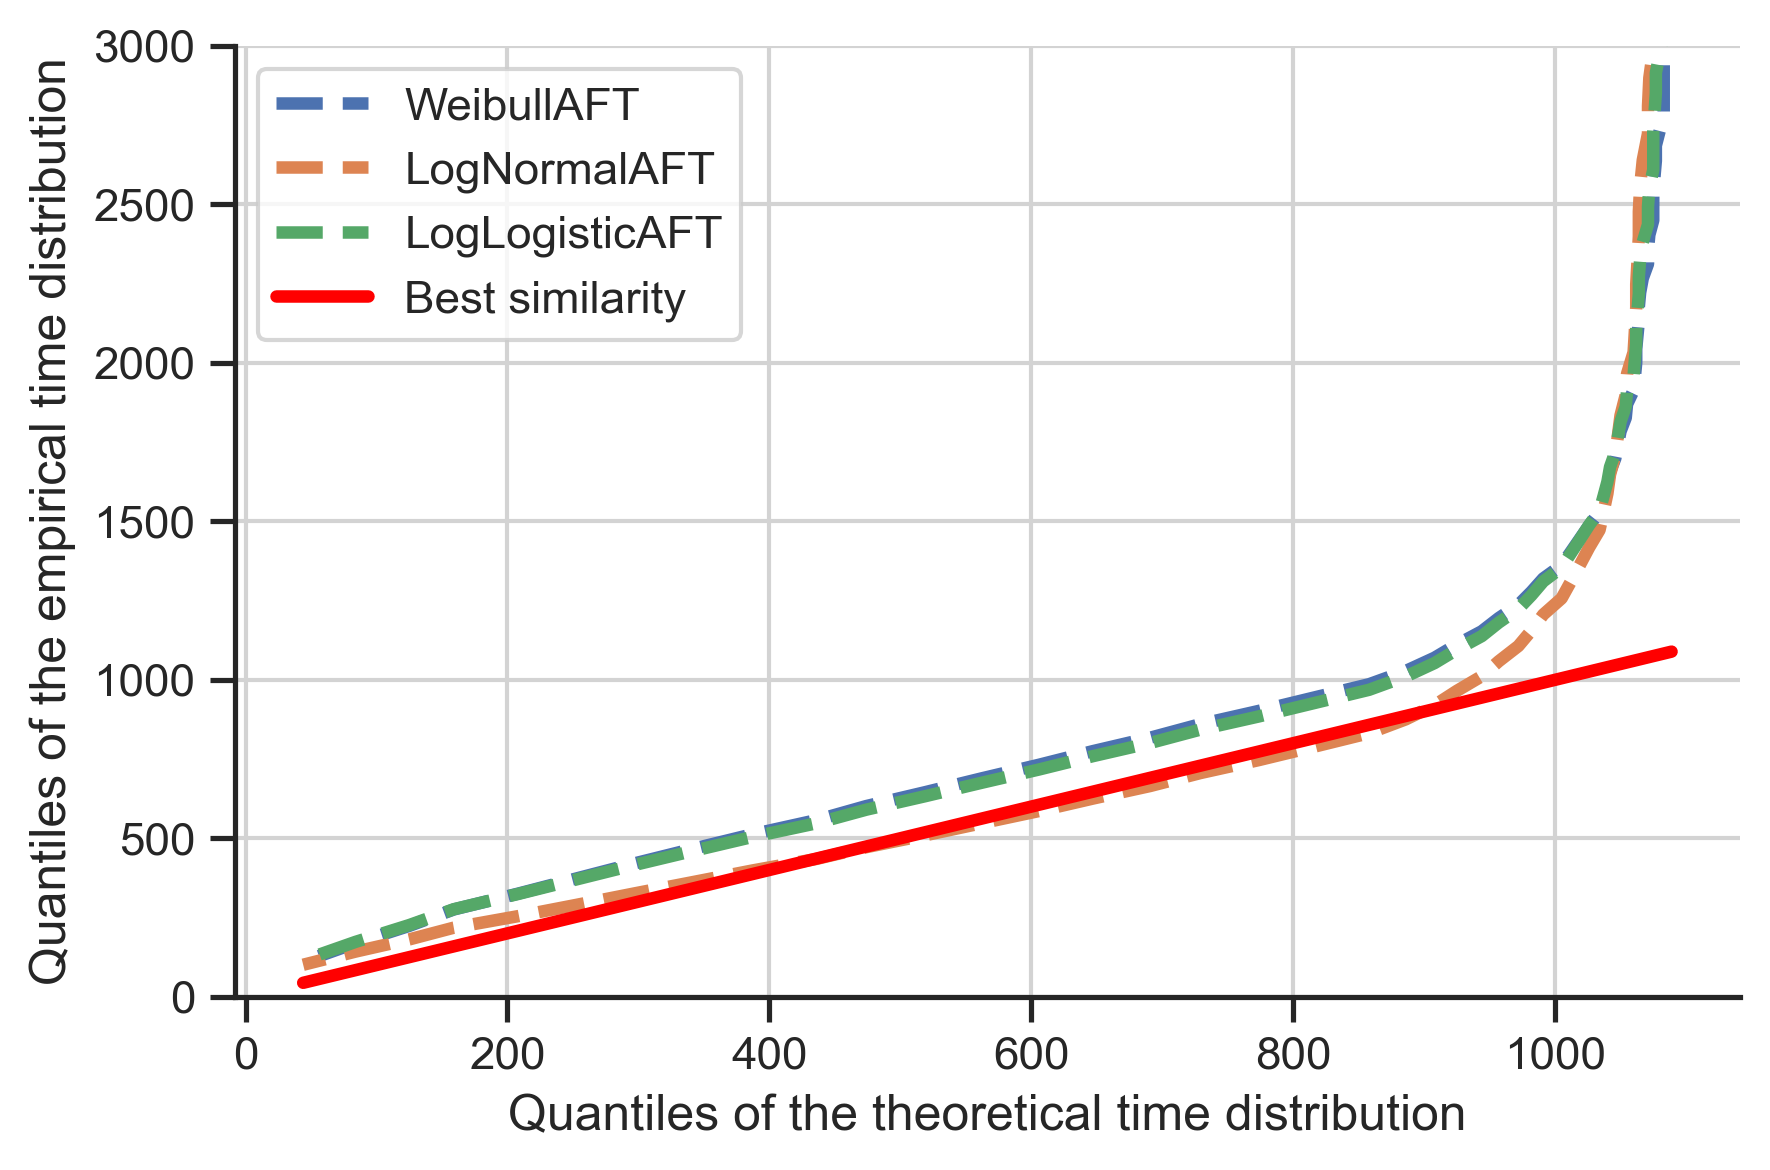

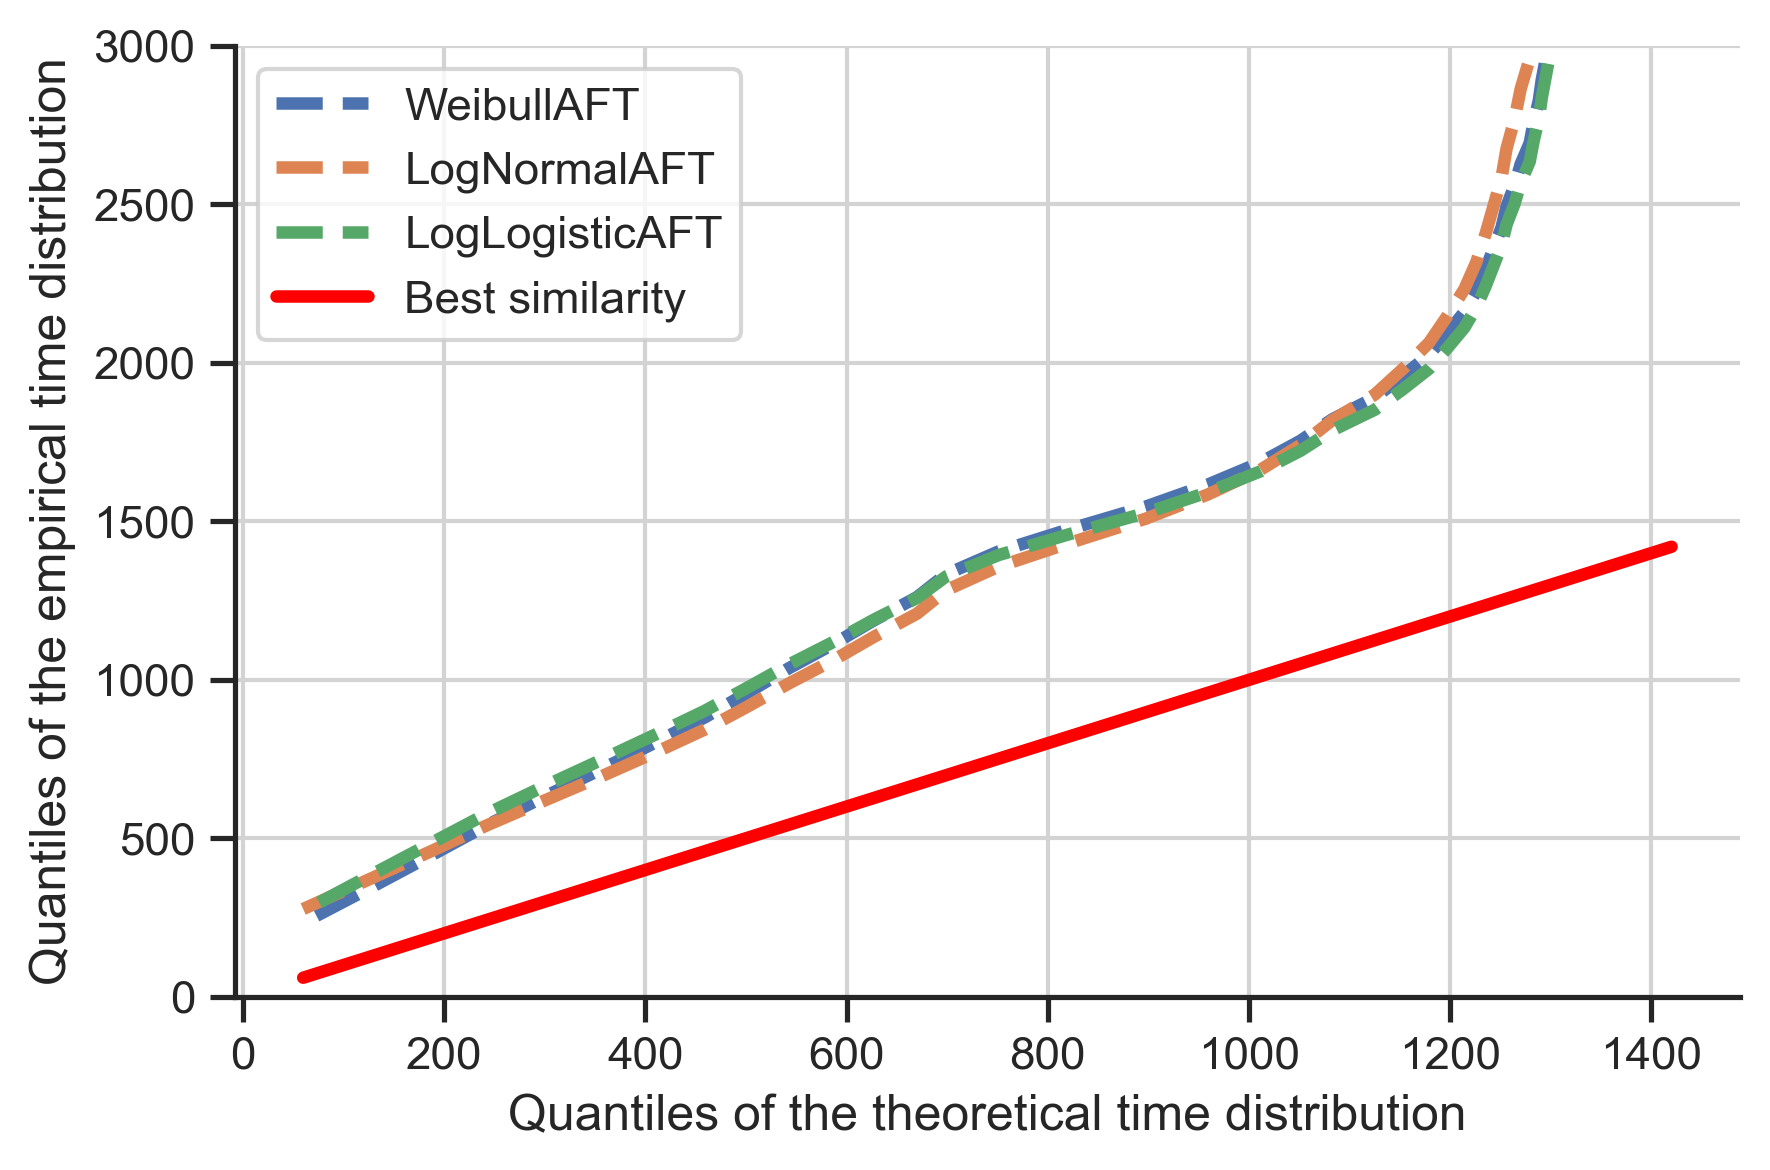

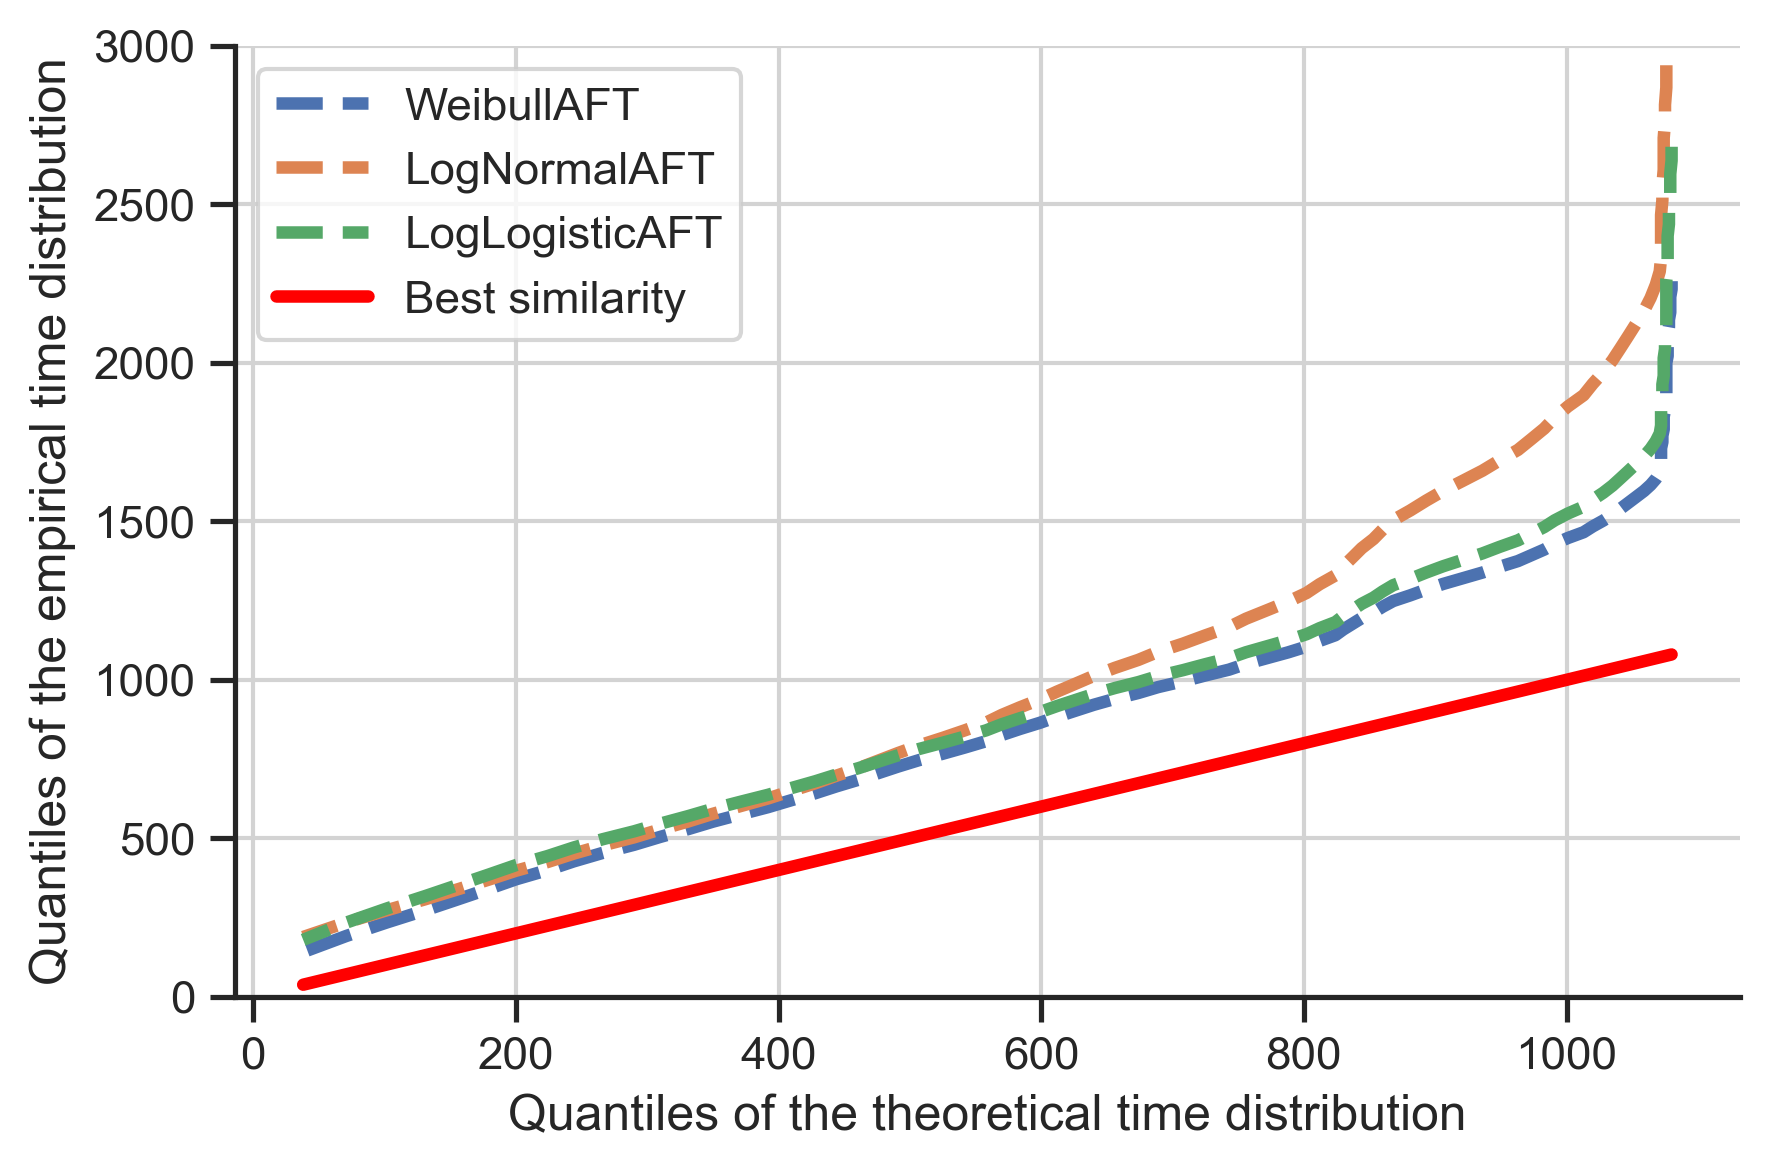

In [124]:
for loader in [ds.load_backblaze_2016_2018, ds.load_backblaze_2018_2021, ds.load_backblaze_2021_2023]:
    X, y, features, categ, _ = loader()
    df = X.fillna(0).copy()
    df["time"] = y["time"]
    df["event"] = y["cens"]
    check_assumption(df)

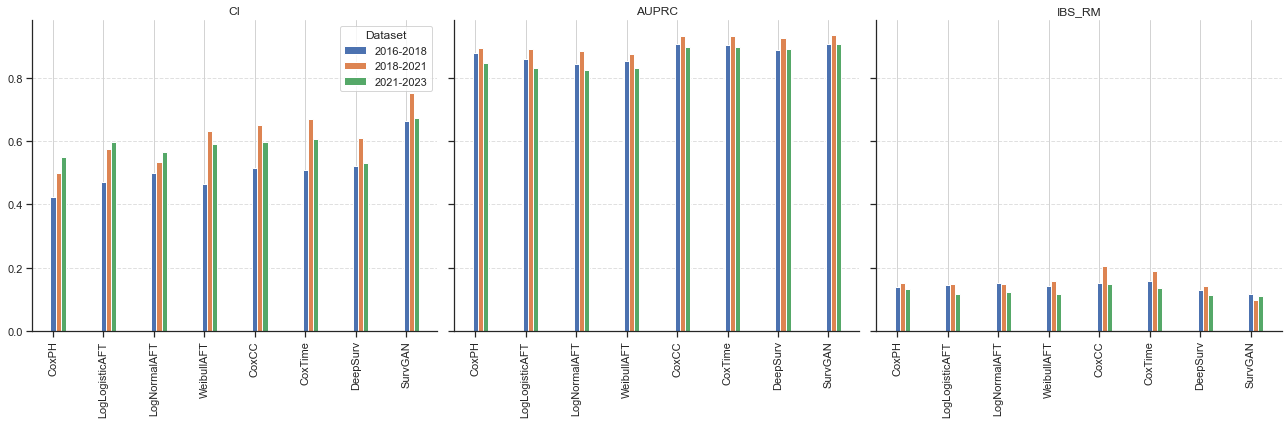

In [129]:
import pandas as pd
import matplotlib.pyplot as plt


# Чтение CSV в DataFrame
df = pd.read_csv("./exp.csv")

# Настройки графиков
metrics = ["CI", "AUPRC", "IBS_RM"]
datasets = ["2016-2018", "2018-2021", "2021-2023"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, metric in enumerate(metrics):
    plot_data = []
    for j, dataset in enumerate(datasets):
        col = f"{metric}_{dataset.replace('-', '_')}"
        temp_df = pd.DataFrame({
            "Method": df["METHOD"],
            "Value": df[col],
            "Dataset": dataset
        })
        plot_data.append(temp_df)
    plot_df = pd.concat(plot_data)

    # Столбчатая диаграмма
    for idx, dataset in enumerate(datasets):
        subset = plot_df[plot_df["Dataset"] == dataset]
        axes[i].bar(
            x=[x + idx*0.1 for x in range(len(subset))],
            height=subset["Value"],
            width=0.1,
            label=dataset if i == 0 else ""
        )
    axes[i].set_title(metric)
    axes[i].set_xticks(range(len(df["METHOD"])))
    axes[i].set_xticklabels(df["METHOD"], rotation=90)
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)
#     if metric == "IBS_RM":
#         ax.invert_yaxis()  # Для IBS меньше — лучше

axes[0].legend(title="Dataset")
plt.tight_layout()
plt.show()


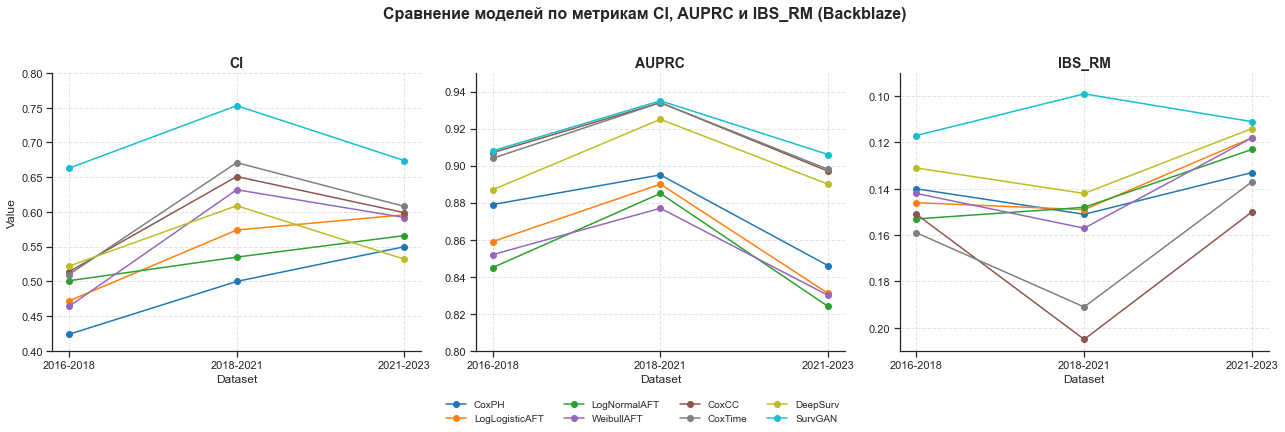

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO

df = pd.read_csv("./exp.csv")

# Настройка единой цветовой схемы
colors = plt.cm.tab10(np.linspace(0, 1, len(df["METHOD"])))
model_colors = dict(zip(df["METHOD"], colors))

# Настройки фигуры
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

metrics = ["CI", "AUPRC", "IBS_RM"]
datasets = ["2016-2018", "2018-2021", "2021-2023"]

for i, metric in enumerate(metrics):
    ax = axes[i]

    for method in df["METHOD"]:
        values = [
            df.loc[df["METHOD"] == method, f"{metric}_2016_2018"].values[0],
            df.loc[df["METHOD"] == method, f"{metric}_2018_2021"].values[0],
            df.loc[df["METHOD"] == method, f"{metric}_2021_2023"].values[0]
        ]
        ax.plot(datasets, values, marker='o', label=method, color=model_colors[method], linewidth=1.5, markersize=6)

    ax.set_title(metric, fontsize=14, fontweight="bold")
    ax.set_xlabel("Dataset", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

    if metric == "CI":
        ax.set_ylim(0.4, 0.8)
    elif metric == "AUPRC":
        ax.set_ylim(0.8, 0.95)
    else:
        ax.set_ylim(0.09, 0.21)
        ax.invert_yaxis()
    
    if metric == "CI":
        ax.set_ylabel("Value", fontsize=12)

# Единая легенда
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=10, frameon=False)

plt.suptitle("Сравнение моделей по метрикам CI, AUPRC и IBS_RM (Backblaze)", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()


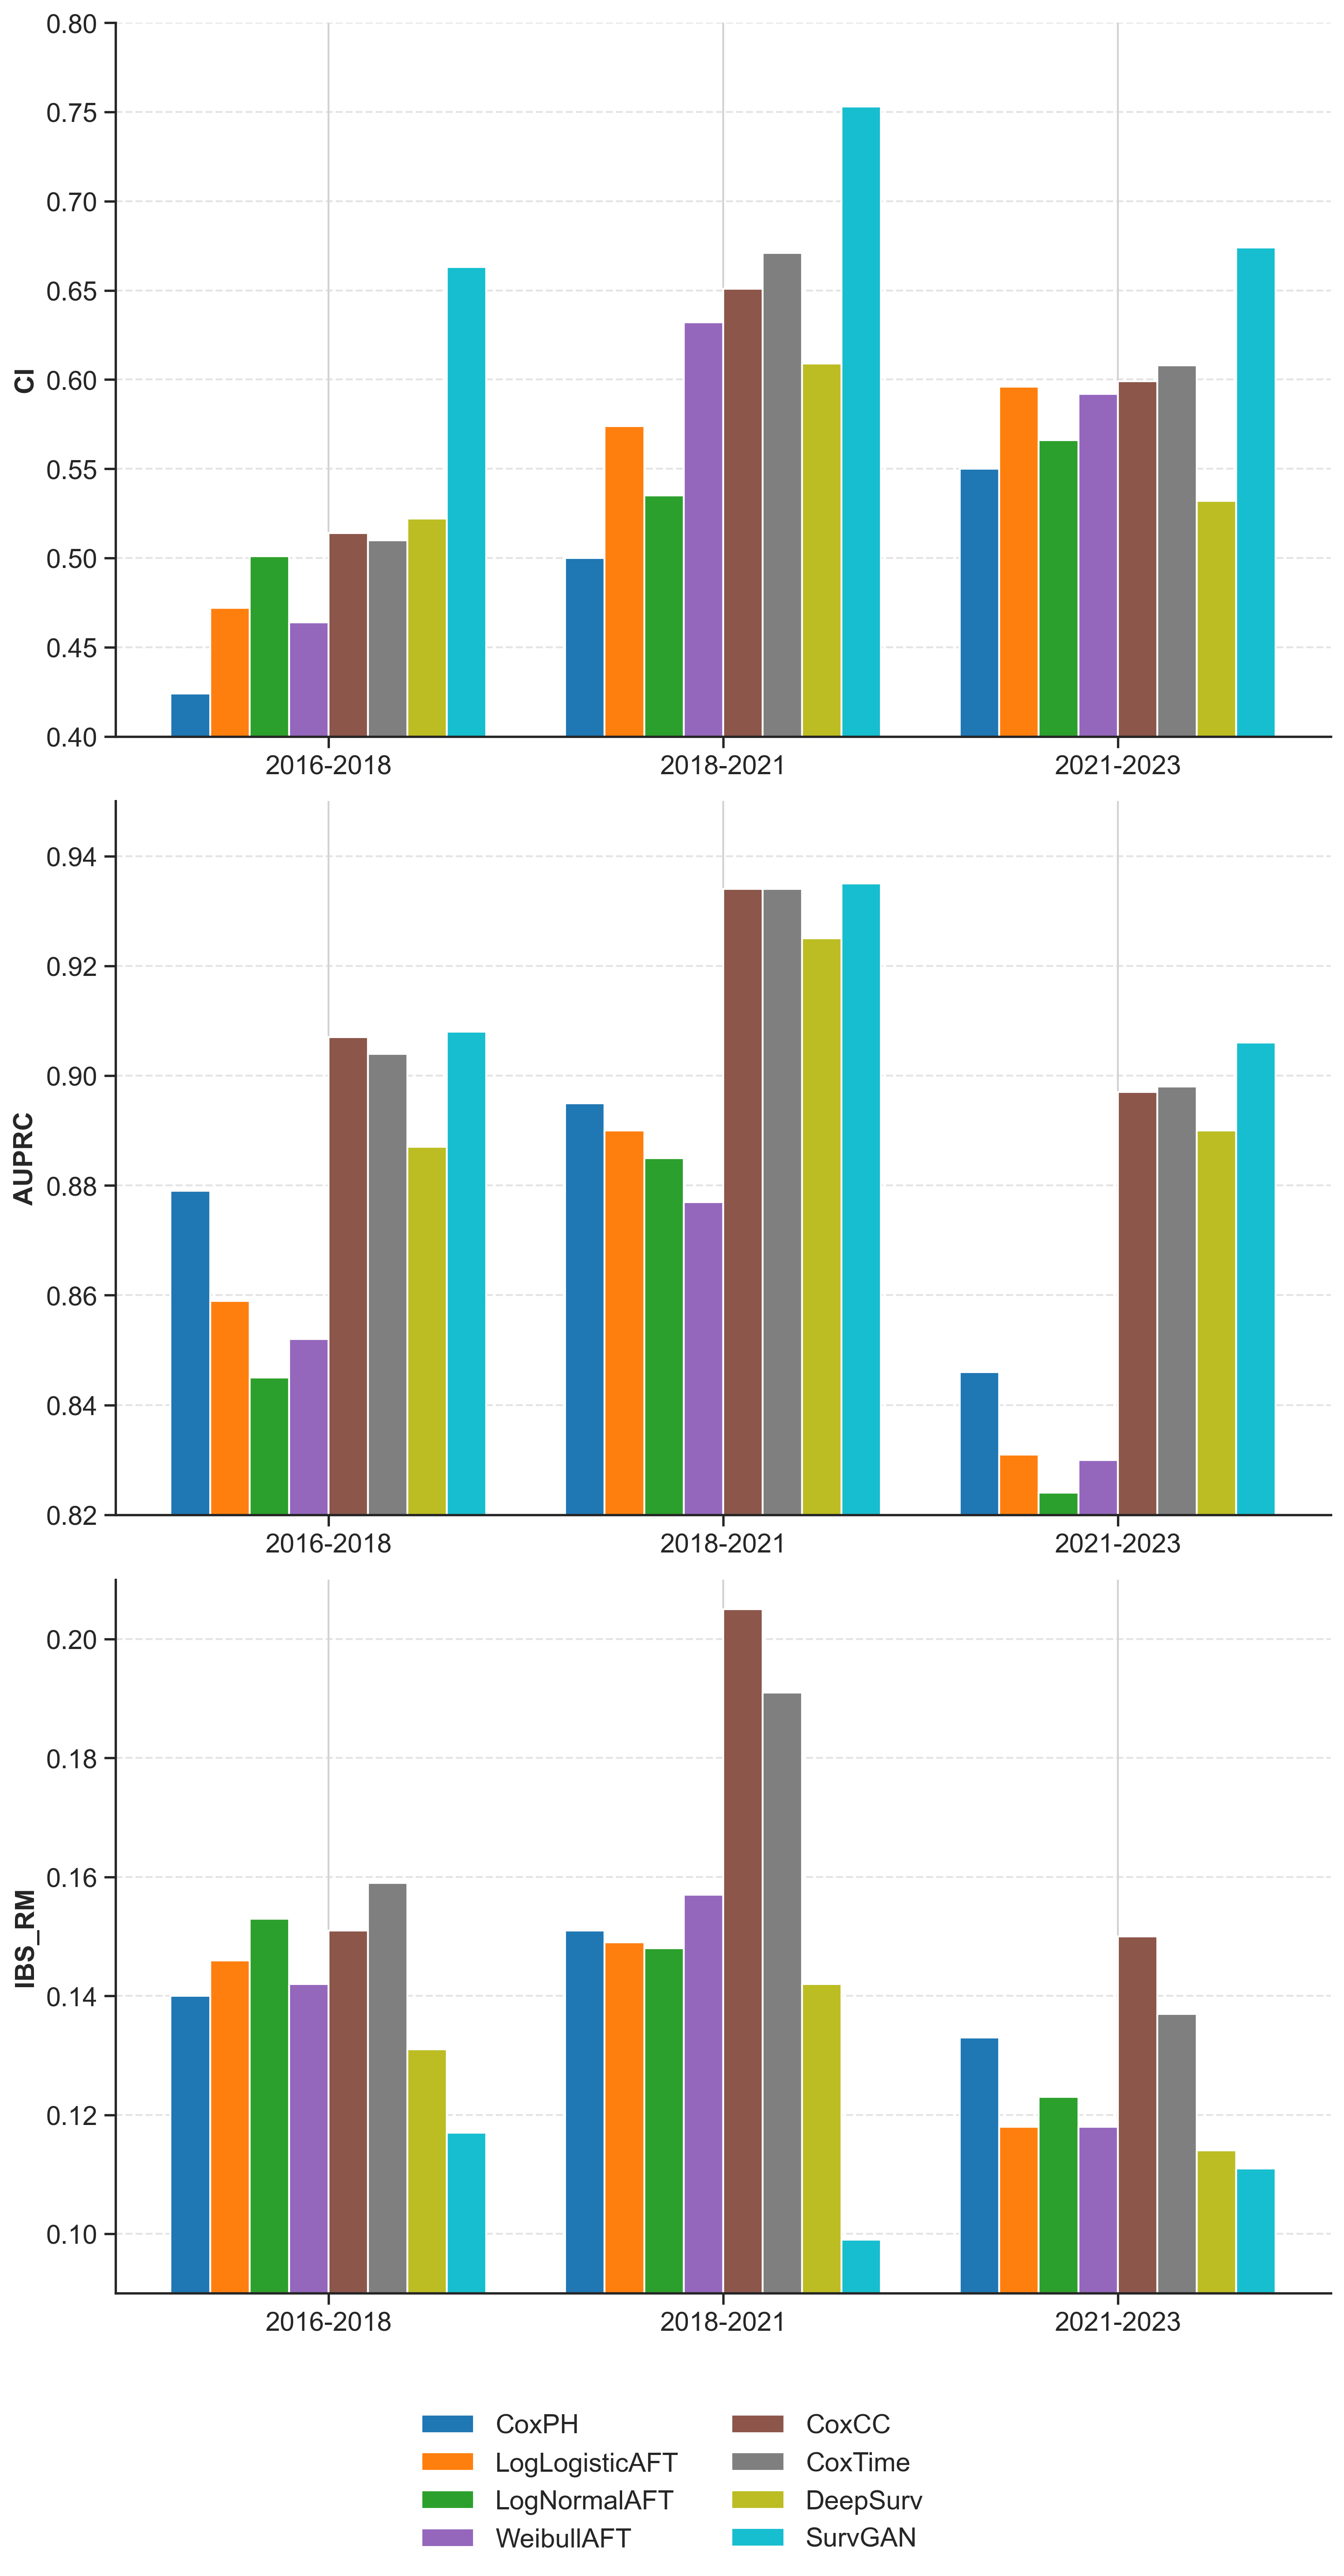

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO

df = pd.read_csv("./exp.csv")

metrics = ["CI", "AUPRC", "IBS_RM"]
datasets = ["2016-2018", "2018-2021", "2021-2023"]

# Цвета для моделей
colors = plt.cm.tab10(np.linspace(0, 1, len(df["METHOD"])))
model_colors = dict(zip(df["METHOD"], colors))

fig, axes = plt.subplots(3, 1, figsize=(10, 20))

bar_width = 0.1
x = np.arange(len(datasets))  # позиции групп

for i, metric in enumerate(metrics):
    ax = axes[i]

    for j, method in enumerate(df["METHOD"]):
        values = [
            df.loc[df["METHOD"] == method, f"{metric}_2016_2018"].values[0],
            df.loc[df["METHOD"] == method, f"{metric}_2018_2021"].values[0],
            df.loc[df["METHOD"] == method, f"{metric}_2021_2023"].values[0]
        ]
        ax.bar(x + j * bar_width, values, width=bar_width,
               label=method if i == 0 else "",
               color=model_colors[method])
    
    ax.tick_params(axis='both', which='major', labelsize=14)
#     ax.set_title(metric, fontsize=14, fontweight="bold")
    ax.set_xticks(x + (len(df["METHOD"]) - 1) * bar_width / 2)
    ax.set_xticklabels(datasets, fontsize=14)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    if metric == "CI":
        ax.set_ylim(0.4, 0.8)
    elif metric == "AUPRC":
        ax.set_ylim(0.82, 0.95)
    else:
        ax.set_ylim(0.09, 0.21)
    ax.set_ylabel(metric, fontsize=14, fontweight="bold")

# axes[0].set_ylabel("Value", fontsize=12)
fig.legend(df["METHOD"], loc="lower center", ncol=2, fontsize=14, frameon=False)
# plt.suptitle("Сравнение моделей по метрикам CI, AUPRC и IBS_RM (Backblaze)", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
fig.set_dpi(300)
plt.savefig("./barplot.png")

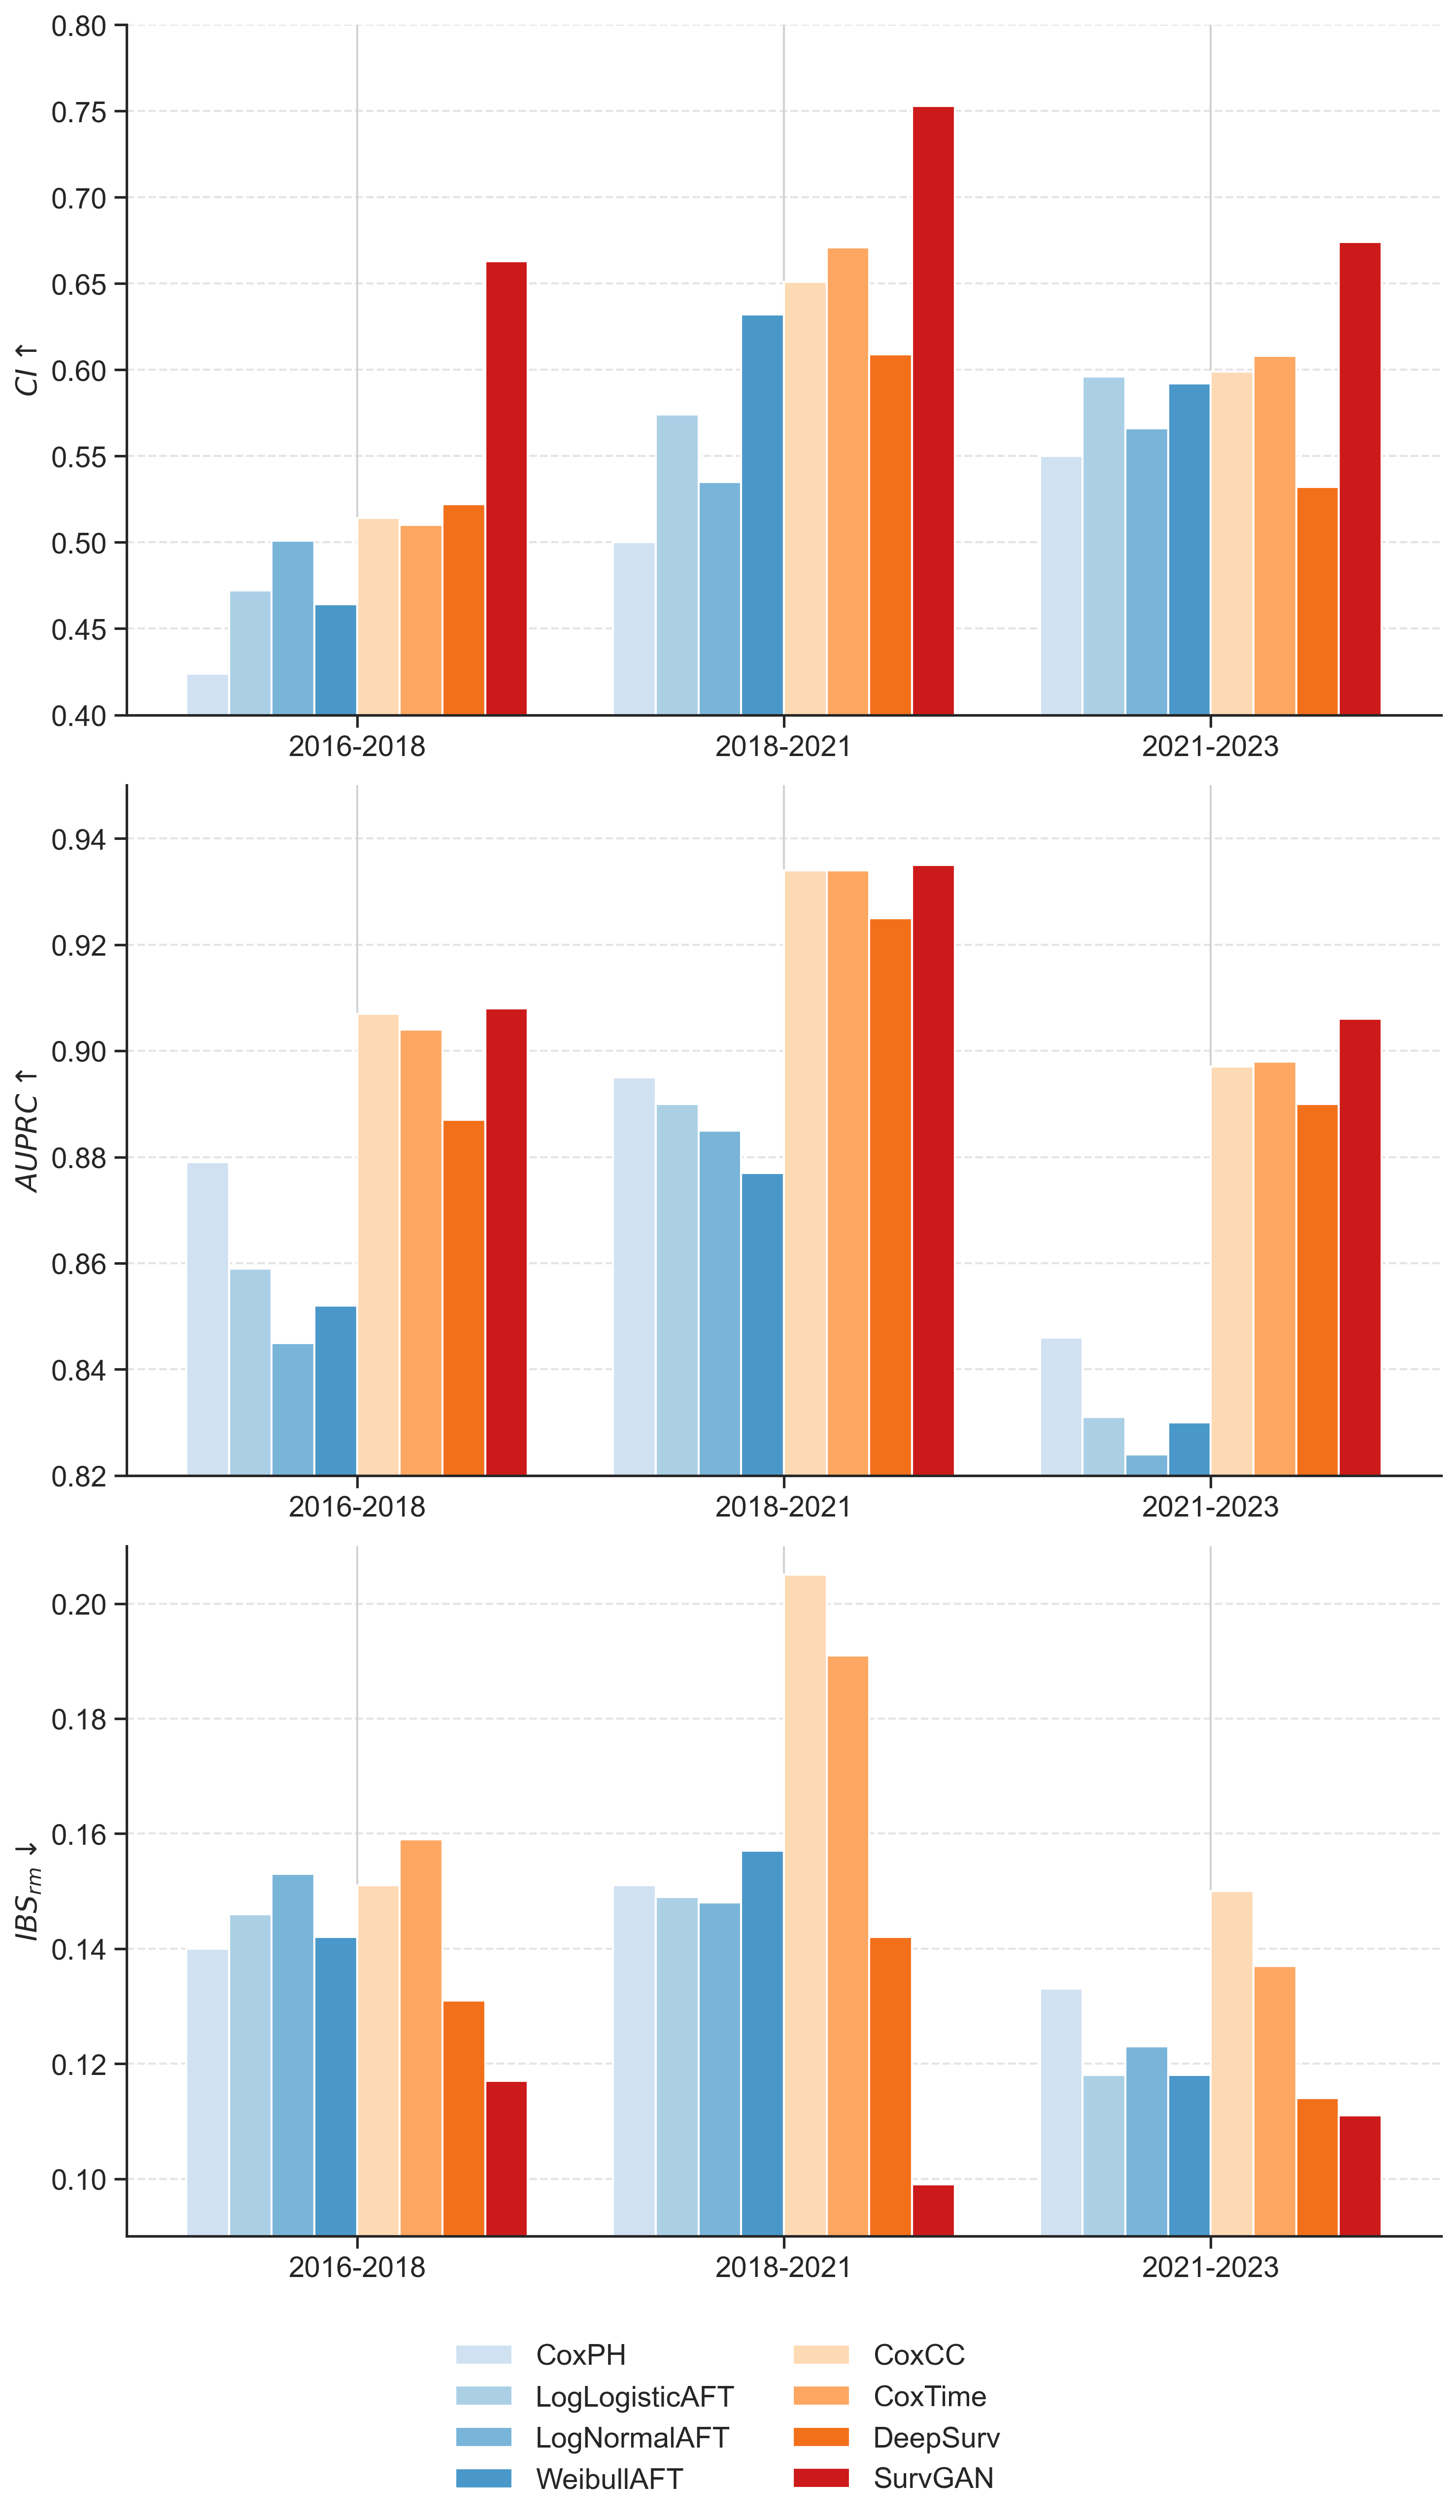

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO

df = pd.read_csv("./exp.csv")

metrics = ["CI", "AUPRC", "IBS_RM"]
datasets = ["2016-2018", "2018-2021", "2021-2023"]

stat_models = ["CoxPH", "LogLogisticAFT", "LogNormalAFT", "WeibullAFT"]
nn_models = ["CoxCC", "CoxTime", "DeepSurv"]
proposed_model = ["SurvGAN"]

color_map = {}
# Синие оттенки для статистических
blue_palette = plt.cm.Blues(np.linspace(0.2, 0.6, len(stat_models)))
for model, color in zip(stat_models, blue_palette):
    color_map[model] = color
# Оранжевые оттенки для нейросетевых
orange_palette = plt.cm.Oranges(np.linspace(0.2, 0.6, len(nn_models)))
for model, color in zip(nn_models, orange_palette):
    color_map[model] = color
# Красный для предложенной модели
color_map["SurvGAN"] = (0.8, 0.1, 0.1)

fig, axes = plt.subplots(3, 1, figsize=(10, 18))

bar_width = 0.1
x = np.arange(len(datasets))  # позиции групп

for i, metric in enumerate(metrics):
    ax = axes[i]

    for j, method in enumerate(df["METHOD"]):
        values = [
            df.loc[df["METHOD"] == method, f"{metric}_2016_2018"].values[0],
            df.loc[df["METHOD"] == method, f"{metric}_2018_2021"].values[0],
            df.loc[df["METHOD"] == method, f"{metric}_2021_2023"].values[0]
        ]
        ax.bar(x + j * bar_width, values, width=bar_width,
               label=method if i == 0 else "",
               color=color_map[method])

    ax.tick_params(axis='both', which='major', labelsize=14)
#     ax.set_title(metric, fontsize=14, fontweight="bold")
    ax.set_xticks(x + (len(df["METHOD"]) - 1) * bar_width / 2)
    ax.set_xticklabels(datasets, fontsize=14)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    if metric == "CI":
        ax.set_ylim(0.4, 0.8)
        ax.set_ylabel(r"$CI \uparrow$", fontsize=14, fontweight="bold")
    elif metric == "AUPRC":
        ax.set_ylim(0.82, 0.95)
        ax.set_ylabel(r"$AUPRC \uparrow$", fontsize=14, fontweight="bold")
    else:
        ax.set_ylim(0.09, 0.21)
        ax.set_ylabel(r"$IBS_{rm} \downarrow$", fontsize=14, fontweight="bold")

fig.legend(df["METHOD"], loc="lower center", ncol=2, fontsize=14, frameon=False)
# plt.suptitle("Сравнение моделей по метрикам CI, AUPRC и IBS_RM (Backblaze)", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
fig.set_dpi(300)
plt.savefig("./barplot.png")